In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [3]:
data=pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/Measles/cameroon.csv",index_col='Year-Month', parse_dates=['Year-Month'], dayfirst=False)


In [4]:
data

,Cases
Year-Month,
2011-01-01,58
2011-02-01,147
2011-03-01,186
2011-04-01,105
2011-05-01,114
...,...
2023-11-01,16
2023-12-01,25
2024-01-01,73


In [12]:
dt=data.rename({'Cases' : 'cases'}, axis=1)
dt

,cases
Year-Month,
2011-01-01,58
2011-02-01,147
2011-03-01,186
2011-04-01,105
2011-05-01,114
...,...
2023-11-01,16
2023-12-01,25
2024-01-01,73


In [13]:
df= dt.groupby("Year-Month").sum()

In [14]:
train = dt.iloc[:147]
test = dt.iloc[147:]

In [15]:
len(test)

12

In [16]:
train

,cases
Year-Month,
2011-01-01,58
2011-02-01,147
2011-03-01,186
2011-04-01,105
2011-05-01,114
...,...
2022-11-01,233
2022-12-01,233
2023-01-01,610


In [17]:
train= train.groupby("Year-Month").sum()
test= test.groupby("Year-Month").sum()

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [23]:
hwmodel= ExponentialSmoothing(train["cases"], trend= None, seasonal= None, seasonal_periods= 0,initialization_method="heuristic",use_boxcox=True,damped=False).fit(
    smoothing_level=0.1,
    smoothing_trend=None,
    optimized=True)
hwmodel.summary()

<ipython-input-23-adadaf328a60>:1: FutureWarning: the 'damped' keyword is deprecated, use 'damped_trend' instead.
  hwmodel= ExponentialSmoothing(train["cases"], trend= None, seasonal= None, seasonal_periods= 0,initialization_method="heuristic",use_boxcox=True,damped=False).fit(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:210: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


Dep. Variable:,cases,No. Observations:,147
Model:,ExponentialSmoothing,SSE,5413477.497
Optimized:,False,AIC,1549.554
Trend:,None,BIC,1555.534
Seasonal:,None,AICC,1549.835
Seasonal Periods:,None,Date:,"Fri, 19 Jul 2024"
Box-Cox:,True,Time:,20:26:18
Box-Cox Coeff.:,0.01711,,
,coeff,code,optimized
smoothing_level,0.1000000,alpha,False
initial_level,5.4547814,l.0,False


In [24]:
start = len(train)
end = len(train)+len(test)-1

prd1 = hwmodel.predict(start= start, end= end)

prd1.index = df.index[start: end+1]

print(prd1)

Year-Month
2023-04-01    234.355517
2023-05-01    234.355517
2023-06-01    234.355517
2023-07-01    234.355517
2023-08-01    234.355517
2023-09-01    234.355517
2023-10-01    234.355517
2023-11-01    234.355517
2023-12-01    234.355517
2024-01-01    234.355517
2024-02-01    234.355517
2024-03-01    234.355517
dtype: float64


In [28]:
from sklearn.metrics import mean_squared_error
error = np.sqrt(mean_squared_error(test["cases"],prd1))


from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test["cases"],prd1)


from sklearn.metrics import mean_squared_log_error
msle = mean_squared_log_error(test["cases"],prd1)



def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


mape = mean_absolute_percentage_error(test["cases"], prd1)
print('RMSE: %.2f' % error)
print(f"MAPE: {mape:.2f}%")
print('MAE:  %.2f' % mae)
print('MSLE: %.2f' % msle)

RMSE: 386.45
MAPE: 730.15%
MAE:  298.26
MSLE: 3.92


<Axes: xlabel='Year-Month'>

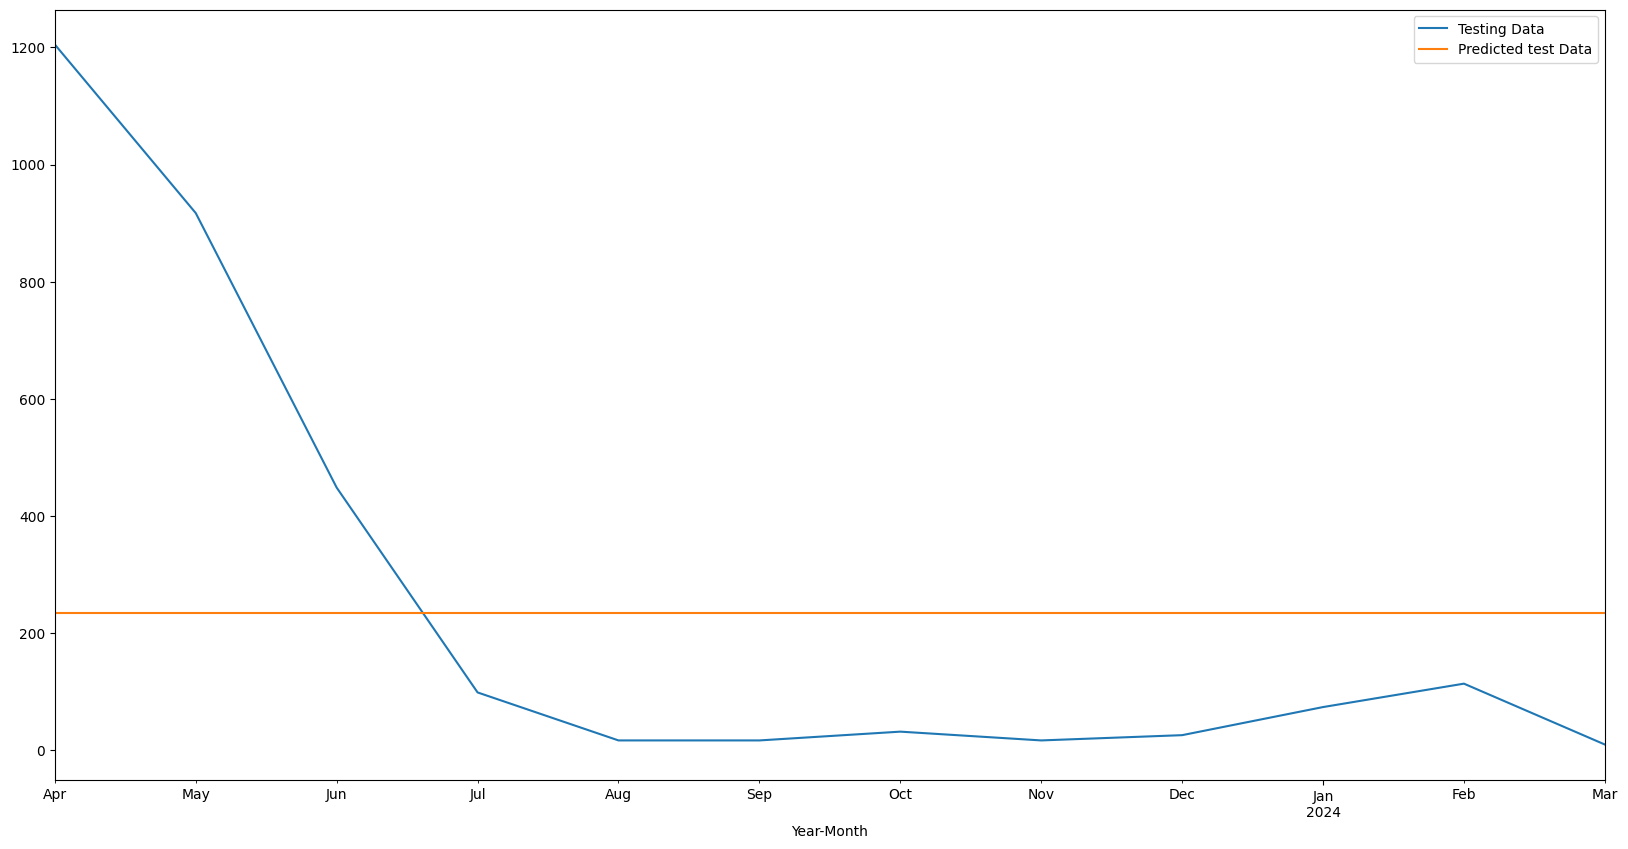

In [30]:
test["cases"].plot(legend= True, label= "Testing Data",figsize=(20,10))
prd1.plot(legend= True, label= "Predicted test Data")